In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Config:
    random_seed = 42
    test_size = 0.1
    n_folds = 0.1
    results = {}

In [3]:
def set_seed(seed=42):
    np.random.seed(seed)
    # random.seed(seed)

set_seed(Config.random_seed)

In [4]:
df = pd.read_csv('./train_ml.csv')
test_df = pd.read_csv('./new_test_ml.csv', index_col=0)

df.head(n=3)

,bank,feeds,grades,date
0,ubrr,"Много лет являюсь клиентом этого банка, но пос...",1.0,16.02.2017 16:10
1,fk_otkritie,"Г. Ростов-на-Дону, ул. Ленина, 48. Были 10.12....",2.0,13.12.2016 1:05
2,alfabank,Здравствуйте!Ранее уже оставлял отзыв о вашем ...,NaN,28.06.2019 13:54


In [5]:
test_df.head()

,bank,feeds,date
0,sberbank,Оформляем ипотеку в Сбербанке. 22.06.2020 были...,01.07.2020 10:53
1,alfabank,Краткое содержание: не рекомендую брать кредит...,20.06.2019 13:19
2,v-express-bank,"Добрый день, уважаемые сотрудники службы контр...",20.02.2016 11:46
3,homecreditbank,"Обращался за получением карты ""Зеленая польза""...",06.05.2019 15:48
4,vtb,20.05.2016 обратилась в отделение банка на про...,23.05.2016 15:41


In [6]:
df.shape

(75000, 4)

In [7]:
# удаляю все строки из обучающих данных, в которых нет оценки

df.dropna(inplace=True)

In [8]:
# изменяю тип колонки `grades` на тип int8

print(f"{df.grades.nbytes = }")
df = df.astype({'grades': np.int8},)
print(f"{df.grades.nbytes = }")

df.grades.nbytes = 411808
df.grades.nbytes = 51476


In [9]:
# создаю новые признаки на основе имеющихся данных

import datetime

df.date = df.date.apply(lambda i: datetime.datetime.strptime(i, '%d.%m.%Y %H:%M'))
df['bank_name_len'] = df.bank.apply(lambda i: len(i))
df['feed_words'] = df.feeds.apply(lambda i: i.split().__len__())
df['feed_len'] = df.feeds.apply(lambda i: len(i))
df['day_of_week'] = df.date.apply(lambda i: i.isoweekday())
df['is_workday'] = df.day_of_week < 6
df['is_friday'] = df.day_of_week == 5
df['is_monday'] = df.day_of_week == 1

# для тестового датасета
test_df.date = test_df.date.apply(lambda i: datetime.datetime.strptime(i, '%d.%m.%Y %H:%M'))
test_df['bank_name_len'] = test_df.bank.apply(lambda i: len(i))
test_df['feed_words'] = test_df.feeds.apply(lambda i: i.split().__len__())
test_df['feed_len'] = test_df.feeds.apply(lambda i: len(i))
test_df['day_of_week'] = test_df.date.apply(lambda i: i.isoweekday())
test_df['is_workday'] = test_df.day_of_week < 6
test_df['is_friday'] = test_df.day_of_week == 5
test_df['is_monday'] = test_df.day_of_week == 1

df.sample(3)


,bank,feeds,grades,date,bank_name_len,feed_words,feed_len,day_of_week,is_workday,is_friday,is_monday
13059,crediteuropebank,Доброго времени суток. Хотелось бы понять один...,2,2014-06-16 21:17:00,16,123,831,1,True,False,True
52081,pochtabank,"Самый худший банк, в котом когда-либо обслужив...",1,2020-07-11 16:50:00,10,172,1153,6,False,False,False
45837,vozrozhdenie,"Речь пойдёт о Волжском филиале Банка ""Возрожде...",5,2006-10-24 09:25:00,12,205,1415,2,True,False,False


In [10]:
df['mean_word_len'] = df.feeds.apply(lambda x: np.mean([i.__len__() for i in x.split()]))
df['mean_word_len2'] = df.feed_len / df.feed_words

test_df['mean_word_len'] = test_df.feeds.apply(lambda x: np.mean([i.__len__() for i in x.split()]))
test_df['mean_word_len2'] = test_df.feed_len / test_df.feed_words

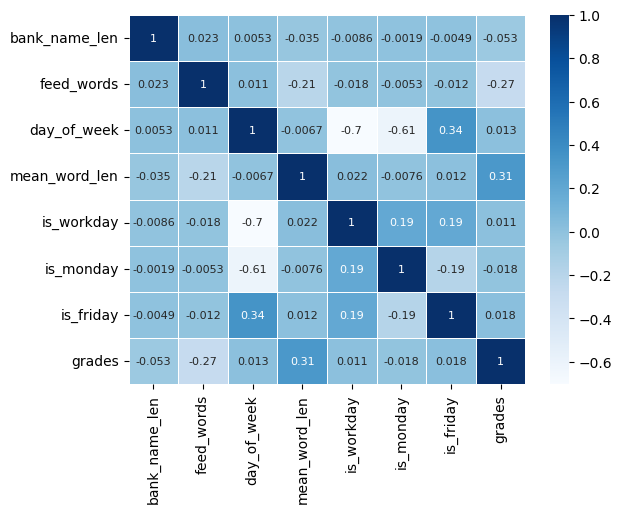

In [11]:
# определяю столбцы с численной информацией
column_names = ['bank_name_len', 'feed_words', 'day_of_week', 'mean_word_len', 'is_workday', 'is_monday', 'is_friday']
corr_data = df[column_names +['grades']]
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(data=corr_data.corr(), annot=True, annot_kws=dict(size=8), cmap='Blues', linewidths=0.5)
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df[column_names], 
    df.grades, 
    test_size=Config.test_size,
    random_state=Config.random_seed,
)

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
test_X = scaler.transform(test_df[column_names])
test_X.shape

(17220, 7)

<Axes: >

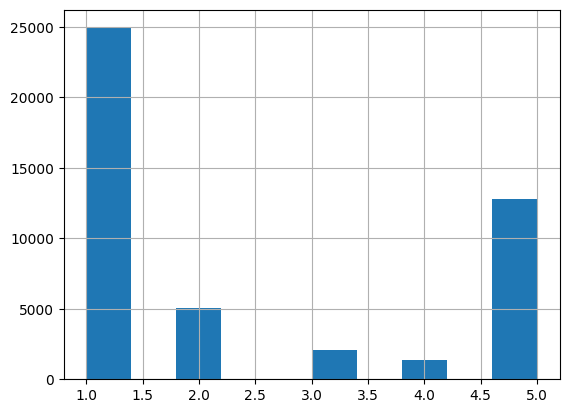

In [15]:
y_train.hist()

In [16]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs',  multi_class='multinomial', max_iter=1000, n_jobs=-1)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_pred_proba = lr.predict_proba(X_test)[:, 1]

In [17]:
pd.Series(lr_pred).value_counts(normalize=True)

1    0.797786
5    0.202214
Name: proportion, dtype: float64

In [18]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import math


def print_results(test_data, predictions, predictions_probas=None, name=None):
    print(f"Classification report:\n{classification_report(test_data, predictions, zero_division=0)}")
    print(f"Confusion matrix:\n{confusion_matrix(test_data, predictions)}")
    # print(f"Accuracy score: {accuracy_score(test_data, predictions, lables=[Config.pos_labels])*100:2.1f}%")
    # print(f"f1 score: {f1_score(test_data, predictions, average='weighted')*100:2.1f}%")

    if name:
        f1_scores = f1_score(test_data, predictions, average='weighted') * 100
        Config.results[name] = f1_scores
    print()
    [print(f"f1 {key}: {value:.3f}%") for key, value in Config.results.items()]
    None

print_results(y_test, lr_pred, lr_pred_proba, 'numerical columns')

Classification report:
              precision    recall  f1-score   support

           1       0.60      0.90      0.72      2759
           2       0.00      0.00      0.00       556
           3       0.00      0.00      0.00       257
           4       0.00      0.00      0.00       146
           5       0.63      0.46      0.53      1430

    accuracy                           0.61      5148
   macro avg       0.25      0.27      0.25      5148
weighted avg       0.50      0.61      0.53      5148

Confusion matrix:
[[2480    0    0    0  279]
 [ 502    0    0    0   54]
 [ 230    0    0    0   27]
 [ 120    0    0    0   26]
 [ 775    0    0    0  655]]

f1 numerical columns: 53.442%


In [19]:
bias_pred = np.ones_like(y_test)

print_results(y_test, bias_pred, name='bias (only ones)')

Classification report:
              precision    recall  f1-score   support

           1       0.54      1.00      0.70      2759
           2       0.00      0.00      0.00       556
           3       0.00      0.00      0.00       257
           4       0.00      0.00      0.00       146
           5       0.00      0.00      0.00      1430

    accuracy                           0.54      5148
   macro avg       0.11      0.20      0.14      5148
weighted avg       0.29      0.54      0.37      5148

Confusion matrix:
[[2759    0    0    0    0]
 [ 556    0    0    0    0]
 [ 257    0    0    0    0]
 [ 146    0    0    0    0]
 [1430    0    0    0    0]]

f1 numerical columns: 53.442%
f1 bias (only ones): 37.401%


In [20]:
test_df_pred = lr.predict(test_X)

In [21]:
test_index = test_df.index
answer = pd.DataFrame(data=test_df_pred, index=test_index, columns=['grades'])
answer.to_csv('my_answer_lr.csv', index_label='inds')

In [22]:
from catboost import CatBoostClassifier

cb = CatBoostClassifier()

In [24]:
cb.fit(X_train, y_train, verbose=0)

In [25]:
cb_pred = cb.predict(X_test)

print_results(y_test, cb_pred, name='cat boost numerical columns')

Classification report:
              precision    recall  f1-score   support

           1       0.62      0.89      0.73      2759
           2       0.00      0.00      0.00       556
           3       0.00      0.00      0.00       257
           4       0.00      0.00      0.00       146
           5       0.63      0.53      0.58      1430

    accuracy                           0.62      5148
   macro avg       0.25      0.28      0.26      5148
weighted avg       0.51      0.62      0.55      5148

Confusion matrix:
[[2450    0    0    0  309]
 [ 490    0    0    0   66]
 [ 225    0    0    0   32]
 [ 115    0    0    0   31]
 [ 671    0    1    0  758]]

f1 numerical columns: 53.442%
f1 bias (only ones): 37.401%
f1 cat boost numerical columns: 55.173%


In [26]:
print(*sorted(zip(column_names, cb.get_feature_importance()), key=lambda i: i[1], reverse=True), sep='\n')

('feed_words', 30.65545179781398)
('mean_word_len', 26.70314450893962)
('bank_name_len', 26.065717323957173)
('day_of_week', 12.365923072931398)
('is_friday', 2.2517422472432433)
('is_workday', 1.146756722080839)
('is_monday', 0.8112643270337376)


In [27]:
pd.Series(cb_pred[:, 0]).value_counts()

1    3951
5    1196
3       1
Name: count, dtype: int64

<Axes: ylabel='Count'>

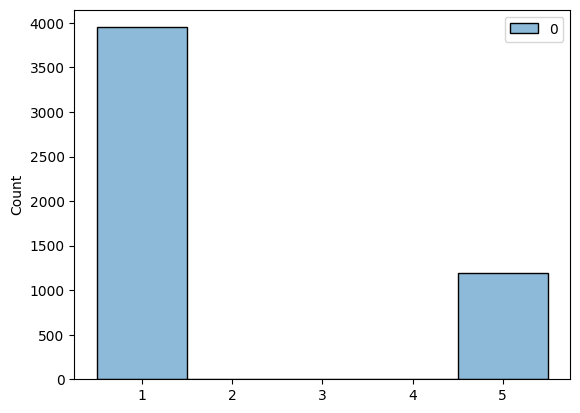

In [28]:
sns.histplot(data=cb_pred, discrete=True)

In [29]:
# Использование CountVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from nltk import ngrams

In [30]:
from nltk.tokenize import RegexpTokenizer

tknzr = RegexpTokenizer(r'[А-Яа-яA-z]+')
words = tknzr.tokenize('12312')
words

[]

In [31]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
# удаляем стоп слова
from nltk.corpus import stopwords

stops = stopwords.words('russian')

def text2tokens(text, tokenizer=__import__('nltk').tokenize.word_tokenize):
    text = text.casefold()
    # return tokenizer(text)
    return tokenizer.tokenize(text)

def remove_stopwords(tokens, stopwords=__import__('nltk').corpus.stopwords.words('russian')):
    return [t for t in tokens if t not in stopwords]

def text_processing(text):
    tokens = text2tokens(text, tokenizer=RegexpTokenizer(r'[А-Яа-яA-z]+'))
    tokens = remove_stopwords(tokens)
    return " ".join(tokens)


from pymystem3 import Mystem
mystem = Mystem()
def lemmatize_text(text):
    try:
        pass
        # tokens = text2tokens(text, tokenizer=RegexpTokenizer(r'[А-Яа-яA-z]+'))
    except Exception as e:
        print('text2tokens: ', text.split(), str(e))

    try:
        if text:
            lemmas = mystem.lemmatize(text)
        else:
            lemmas = []
        #lemmas = mystem.lemmatize(" ".join(tokens))
    except Exception as e:
        print(f"lemmatize: {text}", str(e))
    lemmas = remove_stopwords(lemmas)
    return ''.join([i for i  in lemmas])
    


# text_processing(feed)
# lemmatize_text(text_processing(feed))

In [33]:
from multiprocessing import Pool
from tqdm import tqdm

def f(text):
    return lemmatize_text(text_processing(text))

N = df.feeds.__len__()#1000
lemmas = []
# for i in tqdm(range(N)):
#     lemmas.append(lemmatize_text(text_processing(df.feeds.iloc[i])))

# with Pool(8) as p:
#     lemmas = list(
#         tqdm(
#             p.imap(
#                 f, 
#                 df.feeds.iloc[:N]
#             ),
#             total=N,
#         )
#     )

In [34]:
from functools import lru_cache
import re
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords

regex = re.compile(r'[А-Яа-яA-z]+')

def words_only(text, regex=re.compile(r'[А-Яа-яA-z]+')):
    try:
        return regex.findall(text.casefold())
    except:
        return []

@lru_cache(maxsize=512)
def lemmatize_token(token, pymorph=__import__('pymorphy2').MorphAnalyzer()):
    return pymorph.parse(token)[0].normal_form

def lemmatize_tokens(tokens):
    return [lemmatize_token(token) for token in tokens]

def remove_stopwords(lemmas, stopwords=__import__('nltk').corpus.stopwords.words('russian')):
    return [w for w in lemmas if w not in stopwords]

def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_tokens(tokens)
    return ' '.join(remove_stopwords(lemmas))

In [35]:
from multiprocessing import Pool

N = len(df)
with Pool(16) as p:
    lemmas = list(
        tqdm(
            p.imap(clean_text, df.feeds[:N]),
            total = N
        )
    )



100%|██████████| 51476/51476 [01:07<00:00, 765.66it/s]


In [36]:
test_N = len(test_df)
with Pool(18) as p:
    test_lemmas = list(
        tqdm(
            p.imap(
                clean_text,
                test_df.feeds[:test_N],
            ),
            total = test_N
        )
    )
len(test_lemmas)

100%|██████████| 17220/17220 [00:23<00:00, 746.11it/s]


17220

In [37]:
test_df['lemmas'] = test_lemmas
df['lemmas'] = lemmas

In [38]:
column_names + ['lemmas']

['bank_name_len',
 'feed_words',
 'day_of_week',
 'mean_word_len',
 'is_workday',
 'is_monday',
 'is_friday',
 'lemmas']

In [39]:
numerical_columns = column_names
column_names.append('lemmas')
column_names.append('feeds')
column_names

['bank_name_len',
 'feed_words',
 'day_of_week',
 'mean_word_len',
 'is_workday',
 'is_monday',
 'is_friday',
 'lemmas',
 'feeds']

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[column_names], df.grades, test_size=Config.test_size, random_state=Config.random_seed, stratify=df.grades)
print(f"{X_train.shape = }, {X_test.shape = }")
print(f"{y_train.shape = }, {y_test.shape = }")

X_train.shape = (46328, 9), X_test.shape = (5148, 9)
y_train.shape = (46328,), y_test.shape = (5148,)


In [41]:
X_train[numerical_columns].shape

(46328, 9)

In [42]:
# BoW - Bag of Words

from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(ngram_range=(1, 1))
vec.fit(X_train.lemmas)


CountVectorizer()

In [43]:
bow = vec.transform(X_train.lemmas)

In [44]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(random_state=Config.random_seed,  max_iter=300)

In [45]:
log_clf.fit(bow, y_train)

/root/scripts/python/ml/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=300, random_state=42)

In [46]:
log_pred = log_clf.predict(vec.transform(X_test.lemmas))

<Axes: >

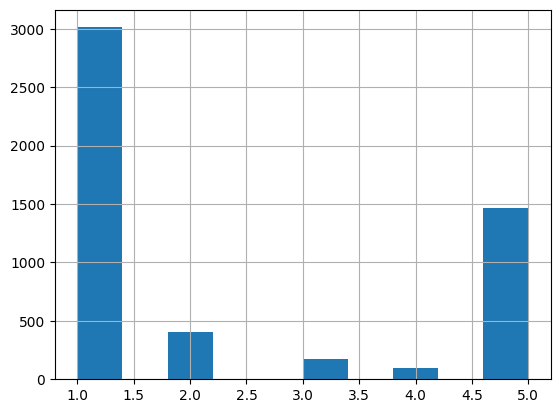

In [47]:
pd.Series(log_pred).hist()

In [48]:
from sklearn.metrics import confusion_matrix

print_results(y_test, log_pred, name='CountVectorizer ngram_range=(1, 1)')

Classification report:
              precision    recall  f1-score   support

           1       0.78      0.85      0.82      2774
           2       0.23      0.16      0.19       563
           3       0.12      0.09      0.11       236
           4       0.14      0.09      0.11       152
           5       0.88      0.90      0.89      1423

    accuracy                           0.73      5148
   macro avg       0.43      0.42      0.42      5148
weighted avg       0.70      0.73      0.71      5148

Confusion matrix:
[[2361  245   89   15   64]
 [ 408   91   34    7   23]
 [ 149   39   22   11   15]
 [  37   10   17   13   75]
 [  58   17   14   47 1287]]

f1 numerical columns: 53.442%
f1 bias (only ones): 37.401%
f1 cat boost numerical columns: 55.173%
f1 CountVectorizer ngram_range=(1, 1): 71.479%


In [49]:
# Функция для отправки тестовых данных
def make_submission(classificator, vectorizer, test_data, filename='my_submission.csv'):
    test_bow = vectorizer.transform(test_data)
    test_predict = classificator.predict(test_bow)

    test_answer = pd.DataFrame(test_predict, columns=['grades'], index=test_df.index)
    test_answer.to_csv(filename, index_label='inds')

In [ ]:
# создаю тестовые данные

# make_submission(
#     vectorizer=vec,
#     test_data=test_df.lemmas,
#     classificator=log_clf,
#     filename='my_answer_count_vectorizer_1_1_log.csv',
# )


In [50]:
# Использую для векторизации ngram_range=(2, 2)

from sklearn.feature_extraction.text import CountVectorizer

vec2 = CountVectorizer(ngram_range=(2, 2))
bow2 = vec2.fit_transform(X_train.lemmas)
print(f"Размер словаря для 2-грамм: {bow2.shape[1]}")


Размер словаря для 2-грамм: 1597515


In [51]:
log2 = LogisticRegression(max_iter=100)
log2.fit(bow2, y_train,)

/root/scripts/python/ml/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [52]:
log2_pred = log2.predict(vec2.transform(X_test.lemmas))

print_results(y_test, log2_pred, name='CountVectorizer ngram_range=(2, 2)')

Classification report:
              precision    recall  f1-score   support

           1       0.75      0.96      0.84      2774
           2       0.28      0.05      0.08       563
           3       0.19      0.02      0.03       236
           4       0.08      0.01      0.01       152
           5       0.88      0.89      0.89      1423

    accuracy                           0.77      5148
   macro avg       0.44      0.39      0.37      5148
weighted avg       0.69      0.77      0.71      5148

Confusion matrix:
[[2667   49    7    2   49]
 [ 507   28    3    2   23]
 [ 194   14    4    3   21]
 [  65    5    5    1   76]
 [ 142    3    2    4 1272]]

f1 numerical columns: 53.442%
f1 bias (only ones): 37.401%
f1 cat boost numerical columns: 55.173%
f1 CountVectorizer ngram_range=(1, 1): 71.479%
f1 CountVectorizer ngram_range=(2, 2): 70.928%


In [53]:
# ngram range= (1, 2)

vec12 = CountVectorizer(ngram_range=(1, 2))
bow12 = vec12.fit_transform(X_train.lemmas)

In [54]:
bow.shape, bow2.shape, bow12.shape

((46328, 59584), (46328, 1597515), (46328, 1657099))

In [55]:
log12 = LogisticRegression(max_iter=200)
log12.fit(bow12, y_train)

/root/scripts/python/ml/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200)

In [56]:
bow12_test = vec12.transform(X_test.lemmas)
log12_pred = log12.predict(bow12_test)

print_results(y_test, log12_pred, name='CountVectorizer ngram_range=(1, 2)')

Classification report:
              precision    recall  f1-score   support

           1       0.77      0.93      0.84      2774
           2       0.27      0.10      0.15       563
           3       0.18      0.06      0.09       236
           4       0.19      0.07      0.10       152
           5       0.89      0.93      0.91      1423

    accuracy                           0.77      5148
   macro avg       0.46      0.42      0.42      5148
weighted avg       0.71      0.77      0.73      5148

Confusion matrix:
[[2581  113   31    8   41]
 [ 469   56   15    6   17]
 [ 165   28   15    9   19]
 [  44    6   14   10   78]
 [  76    3    7   19 1318]]

f1 numerical columns: 53.442%
f1 bias (only ones): 37.401%
f1 cat boost numerical columns: 55.173%
f1 CountVectorizer ngram_range=(1, 1): 71.479%
f1 CountVectorizer ngram_range=(2, 2): 70.928%
f1 CountVectorizer ngram_range=(1, 2): 73.007%


In [ ]:
# сделаем тестовые данные для CountVectorizer(ngram_range=(1, 2))
test_bow = vec12.transform(test_df.lemmas)
test_predict = log12.predict(test_bow)

test_answer = pd.DataFrame(test_predict, columns=['grades'], index=test_df.index)
test_answer.to_csv('my_submission_count_vectorizer_1_2_log.csv', index_label='inds')

In [57]:
# import microsoft boost classifier
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100)

ada.fit(bow12, y_train, )

AdaBoostClassifier(n_estimators=100)

In [58]:
ada_pred = ada.predict(bow12_test)

print_results(y_test, ada_pred, name='AdaBoost CountVectorizer(ngram_range=(1, 2))')

Classification report:
              precision    recall  f1-score   support

           1       0.74      0.96      0.83      2774
           2       0.64      0.02      0.03       563
           3       0.00      0.00      0.00       236
           4       0.25      0.04      0.07       152
           5       0.83      0.87      0.85      1423

    accuracy                           0.76      5148
   macro avg       0.49      0.38      0.36      5148
weighted avg       0.70      0.76      0.69      5148

Confusion matrix:
[[2671    4    1    7   91]
 [ 511    9    1    2   40]
 [ 197    1    0    3   35]
 [  65    0    1    6   80]
 [ 184    0    0    6 1233]]

f1 numerical columns: 53.442%
f1 bias (only ones): 37.401%
f1 cat boost numerical columns: 55.173%
f1 CountVectorizer ngram_range=(1, 1): 71.479%
f1 CountVectorizer ngram_range=(2, 2): 70.928%
f1 CountVectorizer ngram_range=(1, 2): 73.007%
f1 AdaBoost CountVectorizer(ngram_range=(1, 2)): 68.994%


In [ ]:
# AdaBoost показал чуть худшую метрику

In [59]:
# теперь веткоризавтор на основе подсчета tf-idf
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize

tf_vec1 = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize)
tf_bow1 = tf_vec1.fit_transform(X_train.lemmas)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/root/scripts/python/ml/.venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [60]:
tf_log1 = LogisticRegression(max_iter=300)
tf_log1.fit(tf_bow1, y_train)

LogisticRegression(max_iter=300)

In [62]:
tf_bow1_test = tf_vec1.transform(X_test.lemmas)
tf_log1_pred = tf_log1.predict(tf_bow1_test)

print_results(y_test, tf_log1_pred, name='TF-IDF ngram=(1, 1)')

Classification report:
              precision    recall  f1-score   support

           1       0.75      0.98      0.85      2774
           2       0.20      0.02      0.03       563
           3       0.18      0.01      0.02       236
           4       0.50      0.03      0.06       152
           5       0.90      0.92      0.91      1423

    accuracy                           0.78      5148
   macro avg       0.50      0.39      0.38      5148
weighted avg       0.70      0.78      0.72      5148

Confusion matrix:
[[2712   23    3    1   35]
 [ 537   10    3    0   13]
 [ 200   12    3    1   20]
 [  57    3    6    5   81]
 [ 105    3    2    3 1310]]

f1 numerical columns: 53.442%
f1 bias (only ones): 37.401%
f1 cat boost numerical columns: 55.173%
f1 CountVectorizer ngram_range=(1, 1): 71.479%
f1 CountVectorizer ngram_range=(2, 2): 70.928%
f1 CountVectorizer ngram_range=(1, 2): 73.007%
f1 AdaBoost CountVectorizer(ngram_range=(1, 2)): 68.994%
f1 TF-IDF ngram=(1, 1): 71.551%

In [ ]:
test_tf_bow = tf_vec1.transform(test_df.lemmas)
test_tf_predict = tf_log1.predict(test_tf_bow)

test_answer = pd.DataFrame(test_tf_predict, columns=['grades'], index=test_df.index)
test_answer.to_csv('my_submission_tf_idf_ngrams=1_1.csv', index_label='inds')

In [63]:
# Ada Boost Classifier for tf-idf Vectorizer

ada = AdaBoostClassifier(n_estimators=100)
ada.fit(tf_bow1, y_train)


AdaBoostClassifier(n_estimators=100)

In [64]:
ada_pred = ada.predict(tf_bow1_test)

print_results(y_test, ada_pred, name='AdaBoost TF-IDF ngrams=1_1')

Classification report:
              precision    recall  f1-score   support

           1       0.74      0.97      0.84      2774
           2       0.00      0.00      0.00       563
           3       0.00      0.00      0.00       236
           4       0.30      0.07      0.12       152
           5       0.84      0.88      0.86      1423

    accuracy                           0.77      5148
   macro avg       0.38      0.38      0.36      5148
weighted avg       0.64      0.77      0.69      5148

Confusion matrix:
[[2681    0    0    6   87]
 [ 516    0    0    3   44]
 [ 196    0    0    9   31]
 [  61    0    2   11   78]
 [ 161    0    0    8 1254]]

f1 numerical columns: 53.442%
f1 bias (only ones): 37.401%
f1 cat boost numerical columns: 55.173%
f1 CountVectorizer ngram_range=(1, 1): 71.479%
f1 CountVectorizer ngram_range=(2, 2): 70.928%
f1 CountVectorizer ngram_range=(1, 2): 73.007%
f1 AdaBoost CountVectorizer(ngram_range=(1, 2)): 68.994%
f1 TF-IDF ngram=(1, 1): 71.551%

In [65]:
## tf-idf for ngram_range=(1, 2)

tf_vec12 = TfidfVectorizer(ngram_range=(1, 2), stop_words=['russian'], tokenizer=word_tokenize)
tf_vec12.fit(X_train.lemmas)

tf_bow12 = tf_vec12.transform(X_train.lemmas)
tf_bow12_test = tf_vec12.transform(X_test.lemmas)

/root/scripts/python/ml/.venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [66]:
tf_log12 = LogisticRegression(max_iter=100)
tf_log12.fit(tf_bow12, y_train)


Classification report:
              precision    recall  f1-score   support

           1       0.74      0.99      0.85      2774
           2       0.21      0.01      0.01       563
           3       0.33      0.00      0.01       236
           4       0.00      0.00      0.00       152
           5       0.90      0.91      0.91      1423

    accuracy                           0.78      5148
   macro avg       0.44      0.38      0.35      5148
weighted avg       0.69      0.78      0.71      5148

Confusion matrix:
[[2736    5    0    1   32]
 [ 547    3    0    0   13]
 [ 214    3    1    0   18]
 [  66    2    2    0   82]
 [ 121    1    0    0 1301]]

f1 numerical columns: 53.442%
f1 bias (only ones): 37.401%
f1 cat boost numerical columns: 55.173%
f1 CountVectorizer ngram_range=(1, 1): 71.479%
f1 CountVectorizer ngram_range=(2, 2): 70.928%
f1 CountVectorizer ngram_range=(1, 2): 73.007%
f1 AdaBoost CountVectorizer(ngram_range=(1, 2)): 68.994%
f1 TF-IDF ngram=(1, 1): 71.551%

/root/scripts/python/ml/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [67]:
tf_log12_pred = tf_log12.predict(tf_bow12_test)

print_results(y_test, tf_log12_pred, name='TF-IDF ngrams=(1, 2)')

Classification report:
              precision    recall  f1-score   support

           1       0.74      0.99      0.85      2774
           2       0.21      0.01      0.01       563
           3       0.33      0.00      0.01       236
           4       0.00      0.00      0.00       152
           5       0.90      0.91      0.91      1423

    accuracy                           0.78      5148
   macro avg       0.44      0.38      0.35      5148
weighted avg       0.69      0.78      0.71      5148

Confusion matrix:
[[2736    5    0    1   32]
 [ 547    3    0    0   13]
 [ 214    3    1    0   18]
 [  66    2    2    0   82]
 [ 121    1    0    0 1301]]

f1 numerical columns: 53.442%
f1 bias (only ones): 37.401%
f1 cat boost numerical columns: 55.173%
f1 CountVectorizer ngram_range=(1, 1): 71.479%
f1 CountVectorizer ngram_range=(2, 2): 70.928%
f1 CountVectorizer ngram_range=(1, 2): 73.007%
f1 AdaBoost CountVectorizer(ngram_range=(1, 2)): 68.994%
f1 TF-IDF ngram=(1, 1): 71.551%

In [68]:
# использую символьные н-граммы

ch_vec = CountVectorizer(analyzer='char_wb', ngram_range=(3, 3), )
ch_vec.fit(X_train.lemmas)
print(f" Размер словаря:{len(ch_vec.vocabulary_)}")

 Размер словаря:22213


In [69]:
bow_ch1 = ch_vec.transform(X_train.lemmas)
bow_ch1_test = ch_vec.transform(X_test.lemmas)

In [70]:
ch1_log = LogisticRegression(
    multi_class='multinomial',
    max_iter=200,
    random_state=Config.random_seed
)

In [71]:
ch1_log.fit(bow_ch1, y_train)
None

/root/scripts/python/ml/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [72]:
ch1_pred = ch1_log.predict(bow_ch1_test)

print_results(y_test, ch1_pred, name='TF-IDF chars ngrams=(3, 3) ')

Classification report:
              precision    recall  f1-score   support

           1       0.76      0.94      0.84      2774
           2       0.23      0.06      0.09       563
           3       0.12      0.03      0.05       236
           4       0.25      0.09      0.13       152
           5       0.88      0.91      0.89      1423

    accuracy                           0.77      5148
   macro avg       0.45      0.41      0.40      5148
weighted avg       0.69      0.77      0.72      5148

Confusion matrix:
[[2607   78   19   12   58]
 [ 489   33   15    5   21]
 [ 179   20    7   10   20]
 [  46    3   10   14   79]
 [  97    9    6   15 1296]]

f1 numerical columns: 53.442%
f1 bias (only ones): 37.401%
f1 cat boost numerical columns: 55.173%
f1 CountVectorizer ngram_range=(1, 1): 71.479%
f1 CountVectorizer ngram_range=(2, 2): 70.928%
f1 CountVectorizer ngram_range=(1, 2): 73.007%
f1 AdaBoost CountVectorizer(ngram_range=(1, 2)): 68.994%
f1 TF-IDF ngram=(1, 1): 71.551%

In [73]:
# применю н-граммы к оригинальному тексту
ch_vec = CountVectorizer(analyzer='char_wb', ngram_range=(3, 3))
ch_vec.fit(X_train.feeds)
print(f"Размер словаря:{len(ch_vec.vocabulary_)}")

Размер словаря:75756


In [74]:
bow_ch2 = ch_vec.transform(X_train.feeds.apply(lambda x: x.casefold()))
bow_ch2_test = ch_vec.transform(X_test.feeds.apply(lambda x: x.casefold()))

In [75]:
ch2_log = LogisticRegression(
    multi_class='multinomial', 
    max_iter=200,
    random_state=Config.random_seed,
)
ch2_log.fit(bow_ch2, y_train)
None

/root/scripts/python/ml/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [76]:
ch2_pred = ch2_log.predict(bow_ch2_test)

print_results(y_test, ch2_pred, name='TF-IDF feeds chars_wb ngrams=(3, 3)')

Classification report:
              precision    recall  f1-score   support

           1       0.78      0.89      0.83      2774
           2       0.24      0.14      0.17       563
           3       0.14      0.06      0.09       236
           4       0.21      0.12      0.16       152
           5       0.88      0.91      0.90      1423

    accuracy                           0.75      5148
   macro avg       0.45      0.42      0.43      5148
weighted avg       0.70      0.75      0.72      5148

Confusion matrix:
[[2456  196   41   15   66]
 [ 428   77   29    9   20]
 [ 162   31   15   14   14]
 [  36   10   15   19   72]
 [  77   10    7   32 1297]]

f1 numerical columns: 53.442%
f1 bias (only ones): 37.401%
f1 cat boost numerical columns: 55.173%
f1 CountVectorizer ngram_range=(1, 1): 71.479%
f1 CountVectorizer ngram_range=(2, 2): 70.928%
f1 CountVectorizer ngram_range=(1, 2): 73.007%
f1 AdaBoost CountVectorizer(ngram_range=(1, 2)): 68.994%
f1 TF-IDF ngram=(1, 1): 71.551%

In [77]:
# Векториризация TF-IDF 5х5 по исходным данным

vec = TfidfVectorizer(
    lowercase=True, 
    ngram_range=(5, 5), 
    analyzer='char_wb',
    )

vec.fit(X_train.feeds.apply(lambda x: x.casefold()))
print(f"Размер словаря = {vec.vocabulary_.__len__()}")

Размер словаря = 609599


In [78]:
bow = vec.transform(X_train.feeds.apply(lambda x: x.casefold()))
bow_test = vec.transform(X_test.feeds.apply(lambda x: x.casefold()))

In [80]:
lr = LogisticRegression(max_iter=100, multi_class='multinomial', random_state=Config.random_seed)
lr.fit(bow, y_train)
None

/root/scripts/python/ml/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [81]:
lr_pred = lr.predict(bow_test)
print_results(lr_pred, y_test, name='TF-IDF char_wb feeds ngrams=(5, 5)')

Classification report:
              precision    recall  f1-score   support

           1       0.98      0.75      0.85      3613
           2       0.02      0.19      0.03        47
           3       0.01      0.14      0.02        14
           4       0.02      0.38      0.04         8
           5       0.93      0.90      0.92      1466

    accuracy                           0.79      5148
   macro avg       0.39      0.47      0.37      5148
weighted avg       0.95      0.79      0.86      5148

Confusion matrix:
[[2724  538  203   54   94]
 [  20    9   12    2    4]
 [   1    3    2    6    2]
 [   1    1    2    3    1]
 [  28   12   17   87 1322]]

f1 numerical columns: 53.442%
f1 bias (only ones): 37.401%
f1 cat boost numerical columns: 55.173%
f1 CountVectorizer ngram_range=(1, 1): 71.479%
f1 CountVectorizer ngram_range=(2, 2): 70.928%
f1 CountVectorizer ngram_range=(1, 2): 73.007%
f1 AdaBoost CountVectorizer(ngram_range=(1, 2)): 68.994%
f1 TF-IDF ngram=(1, 1): 71.551%

In [97]:
vec = TfidfVectorizer(analyzer='char_wb', ngram_range=(5, 6), min_df=0.0001, max_df=1.0)
X = vec.fit_transform(X_train.feeds.apply(lambda x: x.casefold()))

In [98]:
print(f"Размер словаря: {len(vec.vocabulary_)}")

Размер словаря: 280327


In [99]:
clf = LogisticRegression(max_iter=100, multi_class='multinomial', random_state=Config.random_seed)
clf.fit(X, y_train)


/root/scripts/python/ml/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial', random_state=42)

In [100]:
bow_test = vec.transform(X_test.feeds.apply(lambda x: x.casefold()))
clf_pred = clf.predict(bow_test)

print_results(clf_pred, y_test, name='TF-IDF char_wb feeds ngrams=(5, 6) min_df=0.0001')

Classification report:
              precision    recall  f1-score   support

           1       0.98      0.75      0.85      3623
           2       0.01      0.13      0.02        39
           3       0.01      0.15      0.02        13
           4       0.02      0.50      0.04         6
           5       0.93      0.90      0.91      1467

    accuracy                           0.79      5148
   macro avg       0.39      0.49      0.37      5148
weighted avg       0.96      0.79      0.86      5148

Confusion matrix:
[[2723  542  210   53   95]
 [  18    5    7    2    7]
 [   0    2    2    7    2]
 [   1    1    1    3    0]
 [  32   13   16   87 1319]]

f1 numerical columns: 53.442%
f1 bias (only ones): 37.401%
f1 cat boost numerical columns: 55.173%
f1 CountVectorizer ngram_range=(1, 1): 71.479%
f1 CountVectorizer ngram_range=(2, 2): 70.928%
f1 CountVectorizer ngram_range=(1, 2): 73.007%
f1 AdaBoost CountVectorizer(ngram_range=(1, 2)): 68.994%
f1 TF-IDF ngram=(1, 1): 71.551%

In [85]:
make_submission(
    classificator=clf,
    vectorizer=vec,
    test_data=test_df['feeds'].apply(lambda x: x.casefold()),
    filename='my_submission-tfidf_5_6_char_wb-feeds-logreg.csv'
)

In [ ]:
# разобраться с кодировкой и почему не работает pymystem3
# добавить столбцы c числеными метриками
# перенести диапазон с 1-5 на 0-4 включительно